# **1. Prepare the environment**


In [1]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9ea69bd1-4869-b5e3-afa2-0727c9ad1905)


In [2]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import sys
from IPython.display import Image, display
import matplotlib.cm as cmp

import os
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorflow import keras
import random as rn

In [3]:
#np.random.seed(123)
#tf.random.set_seed(456)
#rn.seed(789)

# **2. Load Data**

In [4]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:

ans_list = ['Long_Eggplant', 'Pea_Eggplant', 'Thai_Eggplant','Tomato']

x0 = np.load('/content/drive/MyDrive/DADS/DADS7202_Deep Learning/Homework/HW02/DataSet/x_Long_Eggplant.npy')
x1 = np.load('/content/drive/MyDrive/DADS/DADS7202_Deep Learning/Homework/HW02/DataSet/x_Pea_Eggplant.npy')
x2 = np.load('/content/drive/MyDrive/DADS/DADS7202_Deep Learning/Homework/HW02/DataSet/x_Thai_Eggplant.npy')
x3 = np.load('/content/drive/MyDrive/DADS/DADS7202_Deep Learning/Homework/HW02/DataSet/x_Tomato.npy')



print(x0.shape)
print(x1.shape)
print(x2.shape)
print(x3.shape)

(150, 224, 224, 3)
(150, 224, 224, 3)
(150, 224, 224, 3)
(150, 224, 224, 3)


In [6]:
y0 = np.array([0 for i in range(150)])
y1 = np.array([1 for i in range(150)])
y2 = np.array([2 for i in range(150)])
y3 = np.array([3 for i in range(150)])

print(y0.shape)
print(y1.shape)
print(y2.shape)
print(y3.shape)

(150,)
(150,)
(150,)
(150,)


In [7]:
x = np.concatenate((x0, x1, x2, x3))
y = np.concatenate((y0, y1, y2, y3))
print(x.shape)
print(y.shape)

(600, 224, 224, 3)
(600,)


In [8]:
#Train Test Split
from sklearn.model_selection import train_test_split

test_size = 0.3
x_train, x_test = train_test_split(x, test_size = test_size, random_state = 60)
y_train, y_test = train_test_split(y, test_size = test_size, random_state = 60)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(420, 224, 224, 3)
(420,)
(180, 224, 224, 3)
(180,)


#**3. Data Preprocess**

In [9]:
#train
# Create the image's data generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                samplewise_center=True,
                                samplewise_std_normalization=True,
                                horizontal_flip=True,
                                vertical_flip=True,
                                validation_split=0.2)     # set validation split
# Fit parameters from the training data
train_datagen.fit(x_train)

===== Train batch no. 1/3 =====


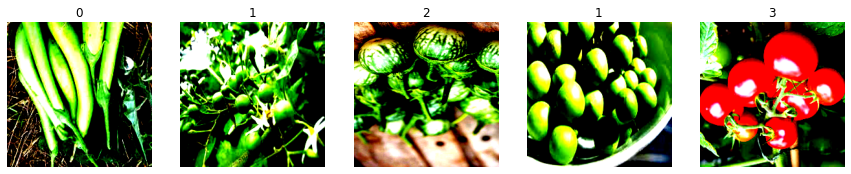

===== Train batch no. 2/3 =====


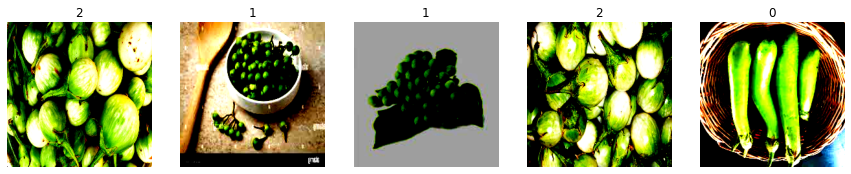

===== Train batch no. 3/3 =====


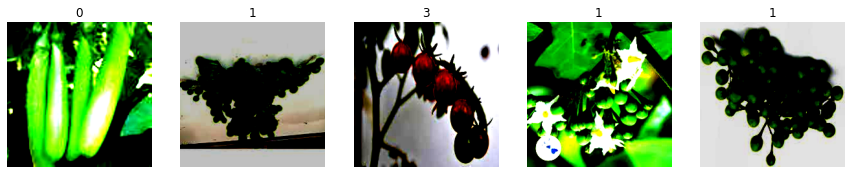

In [10]:
# Visualize some *training* images from the ImageDataGenerator
n_show = 3    # show 'n_show' batches of generated data (1 batch includes 5 images)

for b, (x_batch, y_batch) in enumerate(train_datagen.flow( x_train, y_train, batch_size=5, subset='training' ) ):
  print( f"===== Train batch no. {b+1}/{n_show} =====" )
  plt.figure(figsize=(15,5))
  for i in range(5):
      plt.subplot(150 + 1 + i).set_title( y_batch[i] )                
      plt.imshow( x_batch[i] , cmap='gray' )
      plt.axis( "off" )        # remove all tick marks 
  plt.show()

  if b+1 >= n_show:
    break

===== Train batch no. 1/3 =====


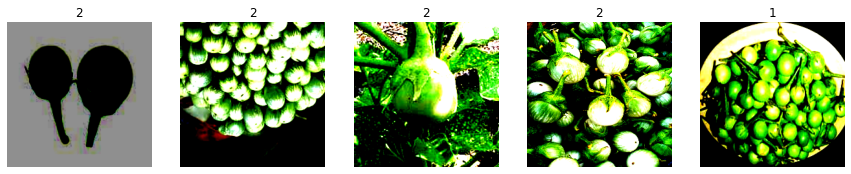

===== Train batch no. 2/3 =====


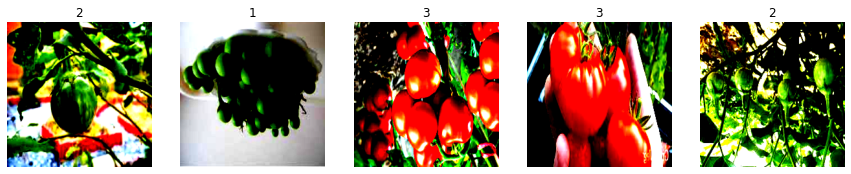

===== Train batch no. 3/3 =====


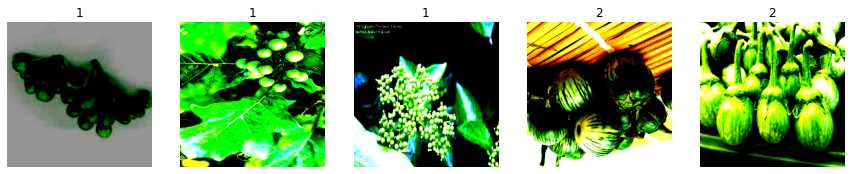

In [11]:
n_show = 3    # show 'n_show' batches of generated data (1 batch includes 5 images)

for b, (x_batch, y_batch) in enumerate( train_datagen.flow( x_train, y_train, batch_size=5, subset='validation' ) ):
  print( f"===== Train batch no. {b+1}/{n_show} =====" )
  plt.figure(figsize=(15,5))
  for i in range(5):
      plt.subplot(150 + 1 + i).set_title( y_batch[i] )                
      plt.imshow( x_batch[i] , cmap='gray' )
      plt.axis( "off" )        # remove all tick marks 
  plt.show()

  if b+1 >= n_show:
    break

# **4. Load the pretrained model**

In [12]:
# Load the ImageNet VGG-16 model, including both the feature extractor part and the classifier part
# By default, VGG-16 is designed for an input image of dimension 224x224x3

#np.random.seed(160)
#tf.random.set_seed(61)

base_model = tf.keras.applications.InceptionResNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False # Not trainable weights

base_model.summary()

219055592/219055592 [==============================] - 1s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)  

In [13]:
#Preprocessing
x_train_preprocess = tf.keras.applications.inception_resnet_v2.preprocess_input(x_train)
x_test_preprocess = tf.keras.applications.inception_resnet_v2.preprocess_input(x_test)

print(x_train_preprocess.shape)
print(x_test_preprocess.shape)

(420, 224, 224, 3)
(180, 224, 224, 3)


In [14]:
#Add new classification head
x = base_model.output

#add custom layer to end of existing model
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
new_outputs = tf.keras.activations.softmax(x)

#Constrauct the main model
model = tf.keras.models.Model(inputs = base_model.inputs, outputs = new_outputs)
model.compile(loss = "sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics = ["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [15]:
from numpy.random import seed
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="save_weight/best_weights.hdf5",  monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint] 

history = model.fit( train_datagen.flow( x_train_preprocess, y_train, batch_size=64, subset='training'),
                            callbacks=[callbacks_list],
                            epochs=10,
                            verbose=1,
                            validation_data=train_datagen.flow(x_train_preprocess, y_train, subset='validation'))

Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 9.4258 - accuracy: 0.2292
Epoch 1: val_accuracy improved from -inf to 0.58333, saving model to save_weight/best_weights.hdf5
6/6 [==============================] - 32s 2s/step - loss: 9.4258 - accuracy: 0.2292 - val_loss: 4.3516 - val_accuracy: 0.5833
Epoch 2/10
6/6 [==============================] - ETA: 0s - loss: 2.7057 - accuracy: 0.6935
Epoch 2: val_accuracy improved from 0.58333 to 0.69048, saving model to save_weight/best_weights.hdf5
6/6 [==============================] - 5s 847ms/step - loss: 2.7057 - accuracy: 0.6935 - val_loss: 3.9929 - val_accuracy: 0.6905
Epoch 3/10
6/6 [==============================] - ETA: 0s - loss: 1.0862 - accuracy: 0.8661
Epoch 3: val_accuracy improved from 0.69048 to 0.72619, saving model to save_weight/best_weights.hdf5
6/6 [==============================] - 5s 844ms/step - loss: 1.0862 - accuracy: 0.8661 - val_loss: 2.9787 - val_accuracy: 0.7262
Epoch 4/10
6/6 [====================

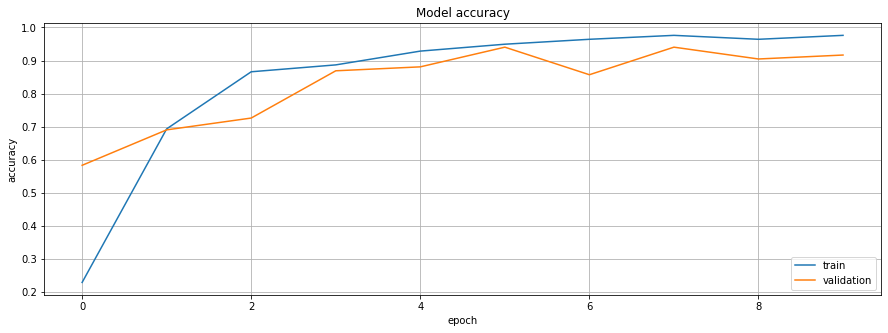

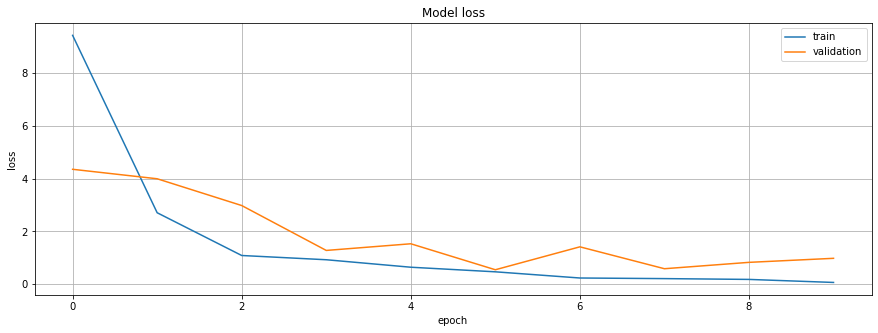

In [16]:
# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

# 5. Evaluate model on test set

In [17]:
model.load_weights('save_weight/best_weights.hdf5')

In [18]:
#Evaluation
results = model.evaluate(x_test_preprocess, y_test, batch_size = 64)
print(f"{model.metrics_names}: {results}")

3/3 [==============================] - 3s 1s/step - loss: 0.1832 - accuracy: 0.9778
['loss', 'accuracy']: [0.18324053287506104, 0.9777777791023254]


1/1 [==============================] - 4s 4s/step


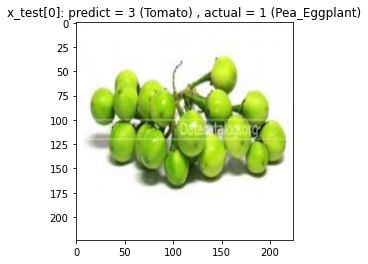

1/1 [==============================] - 0s 34ms/step


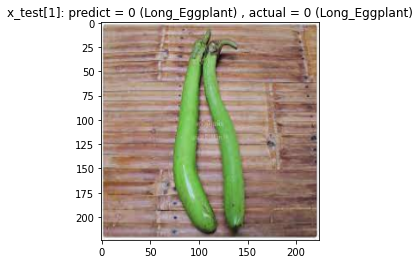

1/1 [==============================] - 0s 36ms/step


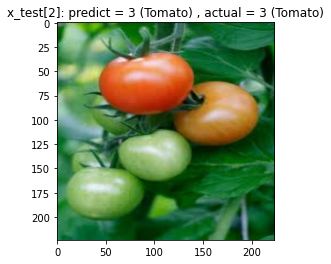

1/1 [==============================] - 0s 40ms/step


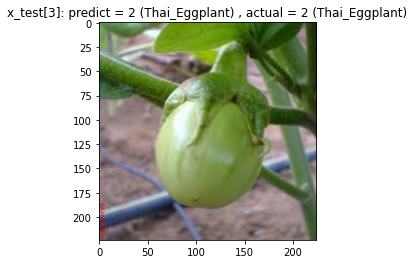

1/1 [==============================] - 0s 36ms/step


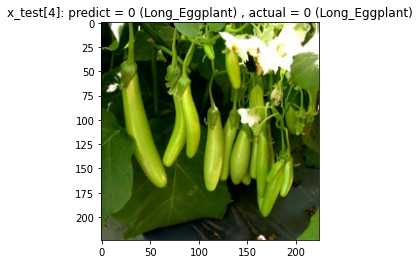

1/1 [==============================] - 0s 35ms/step


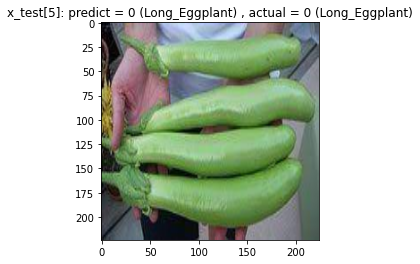

1/1 [==============================] - 0s 35ms/step


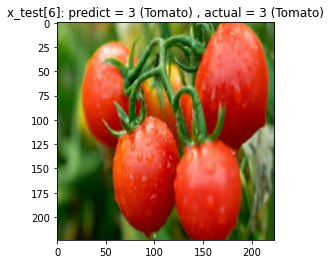

1/1 [==============================] - 0s 40ms/step


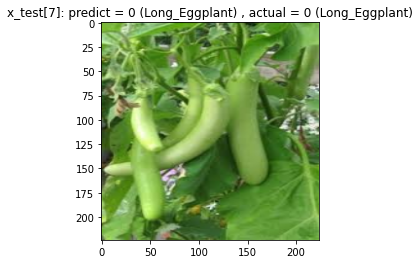

1/1 [==============================] - 0s 38ms/step


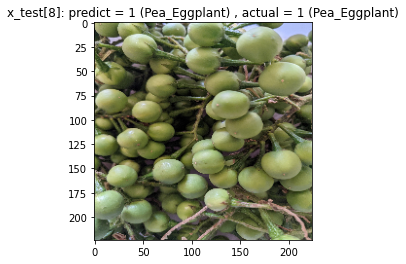

1/1 [==============================] - 0s 36ms/step


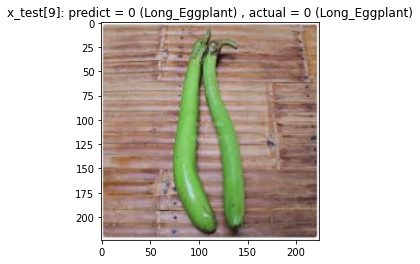

In [19]:
class_name = ans_list
#Test for first 10 images
for i in range(10):
  y_pred = model.predict(x_test_preprocess[i].reshape(1, 224, 224, 3))

  plt.imshow(x_test[i])
  plt.title(f'x_test[{i}]: predict = {np.argmax(y_pred)} ({ans_list[np.argmax(y_pred)]}) , actual = {y_test[i]} ({ans_list[int(y_test[i])]})')
  plt.show()

# 6. Adapt the base model


In [20]:
model.layers[-2].activation

<function keras.activations.relu(x, alpha=0.0, max_value=None, threshold=0.0)>

In [21]:
def alter_model_for_GradCAM( model, last_conv_layer_name ):
  # 1. Get the output from the layer
  last_conv_output = model.get_layer( last_conv_layer_name ).output
  out_linear = model.layers[-2].output
  out_softmax = model.layers[-1].output
  # 3. Create the new model and assign the weight for the 'prediction_linear' layer
  new_model = tf.keras.Model( inputs=model.inputs, outputs=[out_softmax, out_linear, last_conv_output] )

  return new_model

In [22]:
new_model = alter_model_for_GradCAM( model, 'conv_7b')
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [23]:
new_model.output

[<KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'tf.nn.softmax')>,
 <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 5, 5, 1536) dtype=float32 (created by layer 'conv_7b')>]

# **Grad-CAM**

--2022-10-22 16:07:49--  https://wingmarts.com/media/user_299/23627/UBM-V027.jpg
Resolving wingmarts.com (wingmarts.com)... 18.139.31.126, 52.76.85.154
Connecting to wingmarts.com (wingmarts.com)|18.139.31.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50313 (49K) [image/jpeg]
Saving to: ‘UBM-V027.jpg’

UBM-V027.jpg        100%[===================>]  49.13K  --.-KB/s    in 0.001s  

2022-10-22 16:07:49 (33.3 MB/s) - ‘UBM-V027.jpg’ saved [50313/50313]



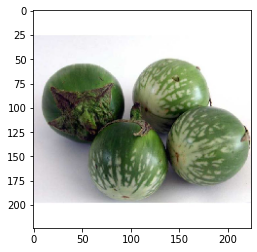

In [24]:
# Load a test image from Internet
img_url =  "https://wingmarts.com/media/user_299/23627/UBM-V027.jpg"
#img_url =  "https://upload.wikimedia.org/wikipedia/commons/6/6c/Tomato-global.png"
#img_url =  "https://wingmarts.com/media/user_299/23627/UBM-V027.jpg"
#img_url = "https://www.calforlife.com/image/food/-Turkey-berry.jpg"
!wget "$img_url"
# Load an image as PIL.Image.IMage
img_path = img_url.split("/")[-1]
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
# Convert PIL Image to Numpy ndarray
img = tf.keras.preprocessing.image.img_to_array(img)
img = img.astype(np.uint8)
# Display the NumPy image
plt.imshow(img)
plt.show()

In [25]:
# Preprocess the input image

img_preprocess = tf.keras.applications.vgg16.preprocess_input( np.expand_dims(img, axis=0))

In [26]:
result = model.predict(img_preprocess)

print(result)

1/1 [==============================] - 0s 68ms/step
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [27]:
def my_CNN_GradCAM( model, in_img, class_index ):
  # Convert from numpy to tensor
  in_img = tf.cast( in_img, tf.float32 )

  # Compute the gradient of y_c with respect to A_i
  with tf.GradientTape() as tape:
    tape.watch(in_img)
    y_softmax, y_linear, last_conv_activation = model( in_img )
    one_class_score = y_linear[..., class_index ]
    gradient = tape.gradient( one_class_score, last_conv_activation )

    # Compute a vector of alphas (one alpha value is one weight for one 2D feature map) by averaging each 2Dgradient
    gradient = gradient.numpy().squeeze(axis=0)
    alpha = np.mean( gradient, axis=(0,1))

    # Compute the weighted-sum heatmap
    last_conv_activation = last_conv_activation.numpy().squeeze(axis=0)
    heatmap = np.dot(last_conv_activation, alpha)

    # Don't hightlight any pixels with negative gradients (= apply ReLU)
    heatmap = np.maximum(0, heatmap)

    # Return an unnormalized heatmap
    return heatmap

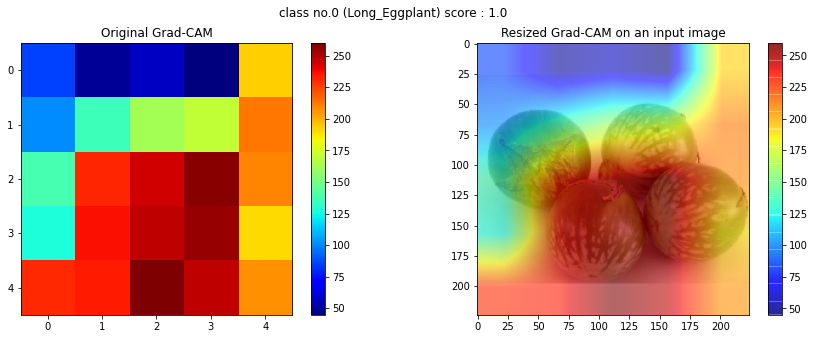

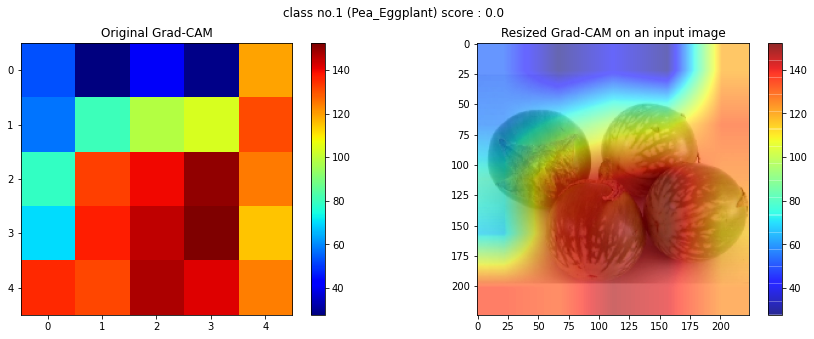

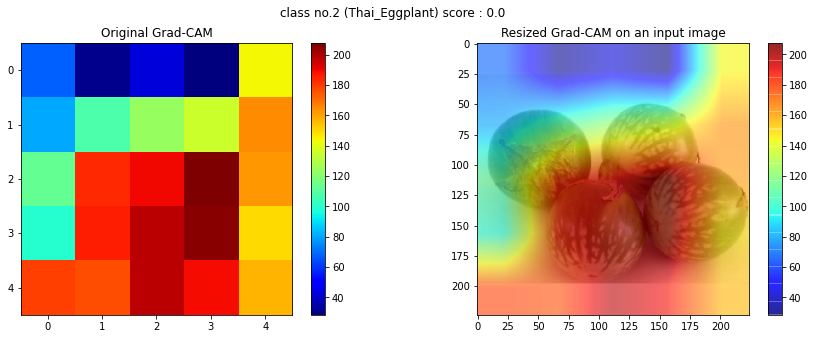

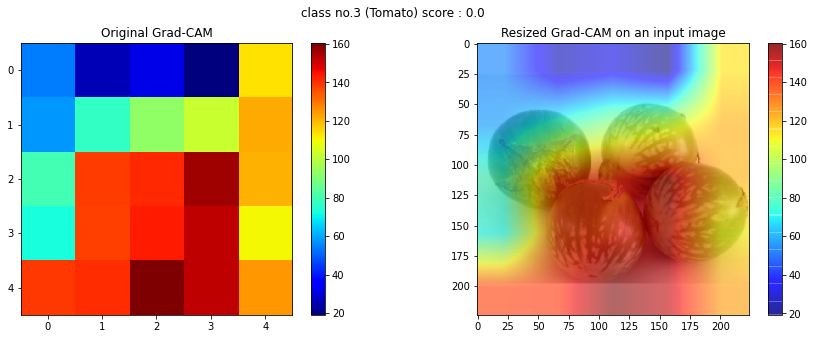

In [28]:
#@title Default title text
# Get predictions with highest scores
top = 4
#_, top_results = my_imagenet_decode_predictions( out_softmax, top=top )
# Extract 0-based class indices
#top_index = [ tp[0] for tp in top_results[0] ]
top_index = [0,1,2,3]
# Visualize Grad-CAM for each class whose index is in 'top_index'
#for i,c in enumerate(top_index):
#class_desc = f"{imagenet_dict[c][-1]}, Top {i+1} score of {out_softmax[...,c].squeeze()}"
for c in range(top):
  heatmap = my_CNN_GradCAM( new_model,       # the CNN model
                            img_preprocess,   # input of the model
                            c                 # the 0-based index of the output class to compute and visualize Grad-CAM
                            )
  # Create the main figure
  fig = plt.figure(figsize=(15,5))
  class_desc = ans_list[c]
  fig.suptitle(f"class no.{c} ({class_desc}) score : {result.item(c)}")
  # Visualize the original heatmap
  ax = fig.add_subplot(1,2,1)
  ax.set_title("Original Grad-CAM")
  im = ax.imshow(heatmap, cmap='jet')
  plt.colorbar(im,ax=ax)
  # Visualize the heatmap overlaid on an input image
  ax = fig.add_subplot(1,2,2)
  ax.set_title("Resized Grad-CAM on an input image")
  ax.imshow(img)
  alpha = 0.6
  im = ax.imshow(cv.resize(heatmap,img.shape[:2]), cmap='jet', alpha=alpha)
  plt.colorbar(im,ax=ax)
  #Show this figure (containing two subplots)
  plt.show()